# Intro
This Jupyter Notebook is used to preprocess the [Kaggle’s BBC News RSS Dataset](https://www.kaggle.com/datasets/gpreda/bbc-news/data) before training a model.

In [ ]:
import sys

# setting path
sys.path.append('../../..') # src folder

file_path = '../../../data/raw/kaggle/bbc_news.csv'
save_path = '../../../data/processed/kaggle/sentiment_inserted.csv'


# Understand the data

In [ ]:
import pandas as pd

# Load the dataset into pandas
bbc_news_df = pd.read_csv(file_path)

# Print the number of rows and columns in the dataset
print(f"Number of rows: {bbc_news_df.shape[0]}")

# Display the first few rows of the dataset to understand its structure
bbc_news_df.head()


Number of rows: 42115


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


## To analyze the distribution by date

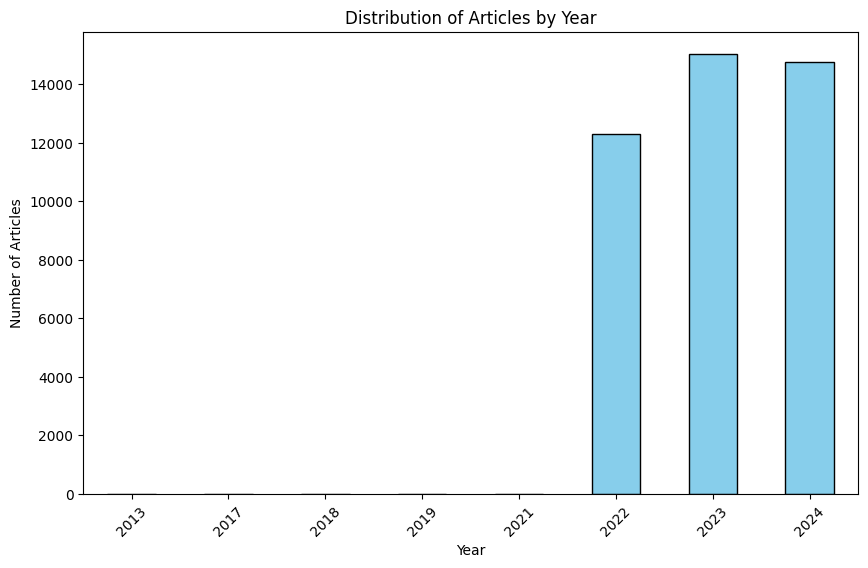

In [15]:
from src.utils.plot_df import plot_distribution_by_year, plot_description_length_distribution

plot_distribution_by_year(bbc_news_df, 'pubDate')

## The length of the description

Since FinBert’s maximum input sequence length is 512 tokens, we need to verify that each description does not exceed this limit to ensure our data can be processed by FinBert.

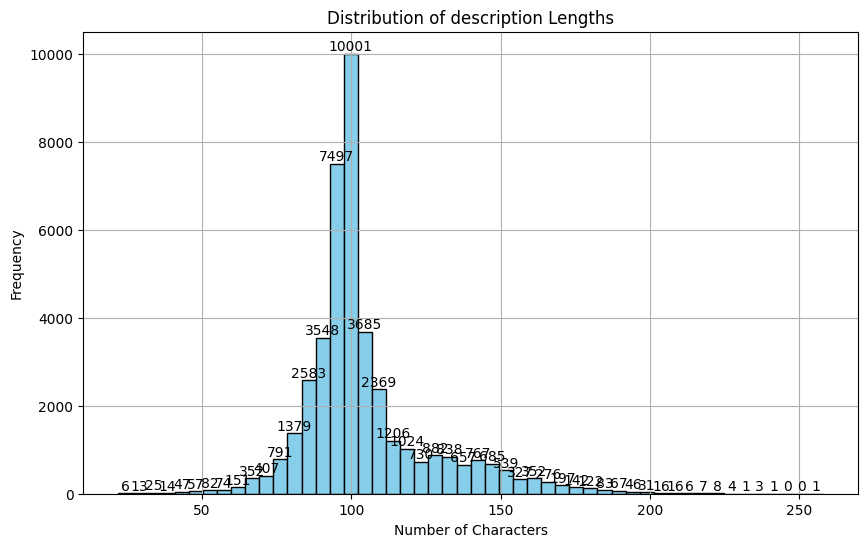

In [16]:
plot_description_length_distribution(bbc_news_df, 'description')

# Data cleaning

## Ensuring data format consistency
Ensuring data format consistency is a crucial step in any machine learning project, especially when working with text data and time-based events.

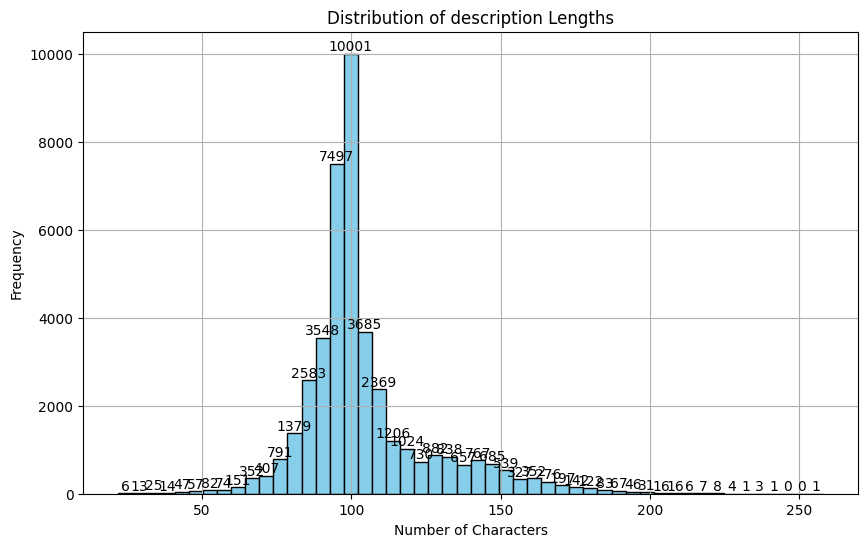

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [17]:
from src.utils.data_format import clean_text_column, convert_datetime_column

# # Text columns
# bbc_news_df = clean_text_column(bbc_news_df, 'title')
# bbc_news_df = clean_text_column(bbc_news_df, 'description')

# Datetime column
bbc_news_df = convert_datetime_column(bbc_news_df, 'pubDate')

# Check the distribution of the cleaned text columns
plot_description_length_distribution(bbc_news_df, 'description')

# Check the cleaned data
bbc_news_df.head()

## Remove the Outlier Data
Since we found that a small number of data points fall outside the march 2022-2024 range, and for the sake of time relevance and consistency within the dataset, we have decided to remove these entries.

In [18]:
# Filter the dataset to keep data between March 2022 and December 2024
start_date = '2022-03-01'
end_date = '2024-12-31'

# Filter the rows based on the specified date range
filtered_df = bbc_news_df[(bbc_news_df['pubDate'] >= start_date) & (bbc_news_df['pubDate'] <= end_date)]

# Print the number of rows in the filtered dataset
print(f"Number of rows in the filtered dataset: {len(filtered_df)}")

Number of rows in the filtered dataset: 42095


## Filter the dataset to keep only the 'news' category

In [19]:
import re

def extract_category(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Extracts categories from the specified column that contains URLs and adds them as a new column.

    Args:
    - df (pd.DataFrame): The pandas dataframe containing the column.
    - column_name (str): The name of the column containing the URLs (guid).

    Returns:
    - pd.DataFrame: The original dataframe with a new column 'category' containing the extracted categories.
    """
    # Function to extract category from a URL
    def get_category(guid: str) -> str:
        match = re.search(r'https?://[^/]+/([^/]+)/', guid)
        if match:
            return match.group(1)
        print(f"Warning: No match found for guid: {guid}")
        return None
        
    # Apply the function to the column and create a new 'category' column
    df['category'] = df[column_name].apply(get_category)
    
    return df

In [20]:
# Assuming the dataframe is already loaded and named `bbc_news_df`
bbc_news_df = extract_category(bbc_news_df, 'guid')

# Count unique categories
unique_categories = bbc_news_df['category'].nunique()

# Display the unique categories and their count
print(f"Number of unique categories: {unique_categories}")
counts = bbc_news_df['category'].value_counts()
print("Count by category:")
for cat, cnt in counts.items():
    print(f"{cat}: {cnt}")

Number of unique categories: 11
Count by category:
news: 33077
sport: 8395
sounds: 406
iplayer: 127
weather: 77
food: 12
articles: 8
newsround: 6
digihub: 3
programmes: 2
mediacentre: 1


## Remove duplicated rows

In [21]:
from src.utils.plot_df import display_duplicate_rows_by_column

# Filter the dataset to keep only the 'news' category
bbc_news_df = bbc_news_df[bbc_news_df['category'] == 'news'].reset_index(drop=True)

# Identify duplicate rows based on a single column 
display_duplicate_rows_by_column(bbc_news_df, 'title')

# Remove some garbage rows
garbage_titles = [
    'BBC News app',
    'Download now'
]

# Sort the dataframe by 'pubDate' in descending order
bbc_news_df = bbc_news_df.sort_values(by='pubDate', ascending=True).reset_index(drop=True)
display(bbc_news_df)

# Filter out the garbage and duplicates titles
bbc_news_df = bbc_news_df[~bbc_news_df['title'].isin(garbage_titles)].reset_index(drop=True)
bbc_news_df = bbc_news_df.drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)

# Check for duplicates in the 'description' and 'link' columns
# Their duplication is likely due to updated titles or descriptions. Using link to identify duplicates
display_duplicate_rows_by_column(bbc_news_df, 'link')
bbc_news_df = bbc_news_df.drop_duplicates(subset=['link'], keep='first').reset_index(drop=True)

display(bbc_news_df)


,title,pubDate,guid,link,description,category
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,news
5,Ukraine war: PM to hold talks with world leade...,2022-03-07 08:33:29+00:00,https://www.bbc.co.uk/news/uk-60642926,https://www.bbc.co.uk/news/uk-60642926?at_medi...,Boris Johnson is to meet the Canadian and Dutc...,news
18,Five ways the Ukraine war could push up prices,2022-03-04 22:09:49+00:00,https://www.bbc.co.uk/news/business-60509453,https://www.bbc.co.uk/news/business-60509453?a...,Prices for everyday items could go up at a tim...,news
44,Covid-19 in the UK: How many coronavirus cases...,2022-03-04 17:34:34+00:00,https://www.bbc.co.uk/news/uk-51768274,https://www.bbc.co.uk/news/uk-51768274?at_medi...,Explore the data on coronavirus in the UK and ...,news
49,Covid: How to look after yourself at home,2022-01-18 12:46:56+00:00,https://www.bbc.co.uk/news/health-59683083,https://www.bbc.co.uk/news/health-59683083?at_...,"What can you expect if you have Covid, and whe...",news
...,...,...,...,...,...,...
32956,Tight three-way race in Irish general election...,2024-11-29 23:29:48+00:00,https://www.bbc.com/news/articles/cz9x9wn802ko#9,https://www.bbc.com/news/articles/cz9x9wn802ko,Voters have been casting their ballot to choos...,news
32957,Could police have handled Skye shooting differ...,2024-11-29 22:57:24+00:00,https://www.bbc.com/news/articles/czxv9z0vdwvo#9,https://www.bbc.com/news/articles/czxv9z0vdwvo,Finlay MacDonald was jailed on Friday for kill...,news
32974,'It's part of my DNA': Charli XCX and the figh...,2024-11-29 18:05:05+00:00,https://www.bbc.com/news/articles/c1dpv363e45o#1,https://www.bbc.com/news/articles/c1dpv363e45o,Can Charli XCX's Brat tour give the UK's club ...,news
32984,Could police have handled Skye shooting differ...,2024-11-30 09:33:58+00:00,https://www.bbc.com/news/articles/czxv9z0vdwvo#8,https://www.bbc.com/news/articles/czxv9z0vdwvo,Finlay MacDonald was jailed on Friday for kill...,news


,title,pubDate,guid,link,description,category
0,Pisces III submersible: A dramatic underwater ...,2013-08-30 01:01:55+00:00,https://www.bbc.co.uk/news/magazine-23862359,https://www.bbc.co.uk/news/magazine-23862359?a...,Fifty years ago two Britons spent three days t...,news
1,Prince's original of Nothing Compares 2 U rele...,2018-04-20 11:30:59+00:00,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,The star's original version of the song was re...,news
2,Grenfell Tower: What happened,2019-10-29 10:27:28+00:00,https://www.bbc.co.uk/news/uk-40301289,https://www.bbc.co.uk/news/uk-40301289?at_medi...,"Images, maps and graphics explaining how the d...",news
3,"Trump: I just want to find 11,780 votes",2021-01-03 21:34:33+00:00,https://www.bbc.co.uk/news/world-us-canada-555...,https://www.bbc.co.uk/news/world-us-canada-555...,US President Donald Trump is heard telling Geo...,news
4,Grenfell Tower inquiry: 9 things we now know a...,2021-03-23 02:24:13+00:00,https://www.bbc.co.uk/news/uk-56403431,https://www.bbc.co.uk/news/uk-56403431?at_medi...,A public inquiry has questioned employees of t...,news
...,...,...,...,...,...,...
33072,'Pickling a cucumber changed my life' says Tik...,2024-12-03 22:37:51+00:00,https://www.bbc.com/news/articles/c0lg82zlyp9o#0,https://www.bbc.com/news/articles/c0lg82zlyp9o,"A film parody actor, a pool cleaner and pickle...",news
33073,Scottish Budget presents huge challenges for SNP,2024-12-03 23:00:17+00:00,https://www.bbc.com/news/articles/ckg1m1j2grpo#9,https://www.bbc.com/news/articles/ckg1m1j2grpo,Finance Secretary Shona Robison is preparing t...,news
33074,Three rail firms to be renationalised next year,2024-12-04 00:02:37+00:00,https://www.bbc.com/news/articles/ceqlnrgjr79o#0,https://www.bbc.com/news/articles/ceqlnrgjr79o,The rail operators will be renationalised in M...,news
33075,School tells Muslim girls it’s ‘not safe’ for ...,2024-12-04 00:03:58+00:00,https://www.bbc.com/news/articles/cx2wk0k4597o#9,https://www.bbc.com/news/articles/cx2wk0k4597o,Three children have not been back to the Belfa...,news


,title,pubDate,guid,link,description,category
9,Are the Conservatives keeping their election p...,2022-01-28 12:58:30+00:00,https://www.bbc.co.uk/news/uk-politics-58401767,https://www.bbc.co.uk/news/uk-politics-5840176...,"The Conservatives made promises on nurses, pol...",news
13,What are the self-isolation rules in England a...,2022-02-24 11:05:57+00:00,https://www.bbc.co.uk/news/explainers-54239922,https://www.bbc.co.uk/news/explainers-54239922...,People with Covid in England are no longer leg...,news
14,When will free Covid tests end in England?,2022-02-24 13:06:04+00:00,https://www.bbc.co.uk/news/health-51943612,https://www.bbc.co.uk/news/health-51943612?at_...,The government is scrapping free Covid tests f...,news
18,Covid boosters: Who will get a fourth dose?,2022-03-02 12:11:20+00:00,https://www.bbc.co.uk/news/health-55045639,https://www.bbc.co.uk/news/health-55045639?at_...,Care workers in England won't need to be vacci...,news
21,What are the UK's 'Living with Covid' plans?,2022-03-04 15:48:28+00:00,https://www.bbc.co.uk/news/explainers-52530518,https://www.bbc.co.uk/news/explainers-52530518...,All legal Covid restrictions in England have e...,news
...,...,...,...,...,...,...
30914,"'I watched porn morning, noon and night'",2024-11-29 21:18:13+00:00,https://www.bbc.com/news/articles/cg57r337rvzo#0,https://www.bbc.com/news/articles/cg57r337rvzo,Excessive masturbation and exhaustion - what h...,news
30957,Holidaymaker killed in Turkey lift-shaft incident,2024-12-01 15:32:52+00:00,https://www.bbc.com/news/articles/c1knkx1z8zgo#8,https://www.bbc.com/news/articles/c1knkx1z8zgo,"Tyler Kerry was ""a young man full of personali...",news
30958,British man killed on holiday in Turkey lift-s...,2024-12-01 15:32:52+00:00,https://www.bbc.com/news/articles/c1knkx1z8zgo#0,https://www.bbc.com/news/articles/c1knkx1z8zgo,"Tyler Kerry was ""a young man full of personali...",news
30972,Final seats to be filled in Irish general elec...,2024-12-02 00:08:08+00:00,https://www.bbc.com/news/articles/cpdnlv8n758o#8,https://www.bbc.com/news/articles/cpdnlv8n758o,"With all 43 constituencies' first counts in, F...",news


,title,pubDate,guid,link,description,category
0,Pisces III submersible: A dramatic underwater ...,2013-08-30 01:01:55+00:00,https://www.bbc.co.uk/news/magazine-23862359,https://www.bbc.co.uk/news/magazine-23862359?a...,Fifty years ago two Britons spent three days t...,news
1,Prince's original of Nothing Compares 2 U rele...,2018-04-20 11:30:59+00:00,https://www.bbc.co.uk/news/entertainment-arts-...,https://www.bbc.co.uk/news/entertainment-arts-...,The star's original version of the song was re...,news
2,Grenfell Tower: What happened,2019-10-29 10:27:28+00:00,https://www.bbc.co.uk/news/uk-40301289,https://www.bbc.co.uk/news/uk-40301289?at_medi...,"Images, maps and graphics explaining how the d...",news
3,"Trump: I just want to find 11,780 votes",2021-01-03 21:34:33+00:00,https://www.bbc.co.uk/news/world-us-canada-555...,https://www.bbc.co.uk/news/world-us-canada-555...,US President Donald Trump is heard telling Geo...,news
4,Grenfell Tower inquiry: 9 things we now know a...,2021-03-23 02:24:13+00:00,https://www.bbc.co.uk/news/uk-56403431,https://www.bbc.co.uk/news/uk-56403431?at_medi...,A public inquiry has questioned employees of t...,news
...,...,...,...,...,...,...
29371,'Pickling a cucumber changed my life' says Tik...,2024-12-03 22:37:51+00:00,https://www.bbc.com/news/articles/c0lg82zlyp9o#0,https://www.bbc.com/news/articles/c0lg82zlyp9o,"A film parody actor, a pool cleaner and pickle...",news
29372,Scottish Budget presents huge challenges for SNP,2024-12-03 23:00:17+00:00,https://www.bbc.com/news/articles/ckg1m1j2grpo#9,https://www.bbc.com/news/articles/ckg1m1j2grpo,Finance Secretary Shona Robison is preparing t...,news
29373,Three rail firms to be renationalised next year,2024-12-04 00:02:37+00:00,https://www.bbc.com/news/articles/ceqlnrgjr79o#0,https://www.bbc.com/news/articles/ceqlnrgjr79o,The rail operators will be renationalised in M...,news
29374,School tells Muslim girls it’s ‘not safe’ for ...,2024-12-04 00:03:58+00:00,https://www.bbc.com/news/articles/cx2wk0k4597o#9,https://www.bbc.com/news/articles/cx2wk0k4597o,Three children have not been back to the Belfa...,news


# Insert Sentiment Score

In [ ]:
from src.utils.sentiment import add_sentiment_scores

# Add sentiment scores to the filtered DataFrame
filtered_df = add_sentiment_scores(filtered_df, 'description')

# Check the first few rows of the DataFrame with sentiment scores
display(filtered_df.head())

# Save the filtered DataFrame with sentiment scores to a CSV file
filtered_df.to_csv(save_path, index=False)

Processing Sentiment Scores:  43%|████▎     | 18242/42095 [17:34<12:54, 30.81text/s]    

## Expore the distribution of sentiment score

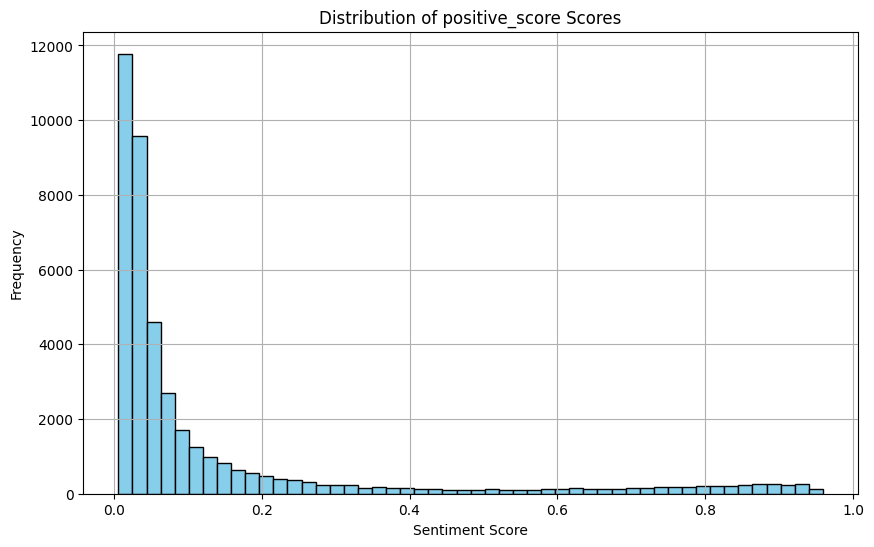

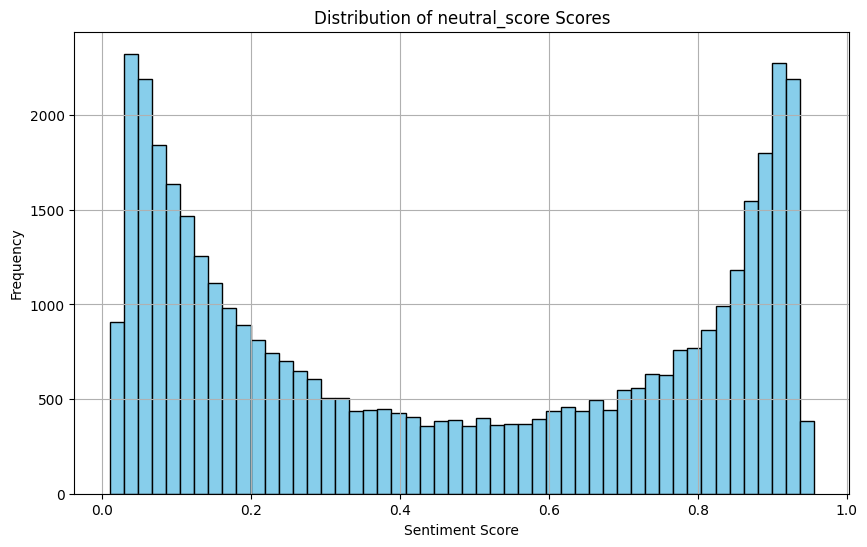

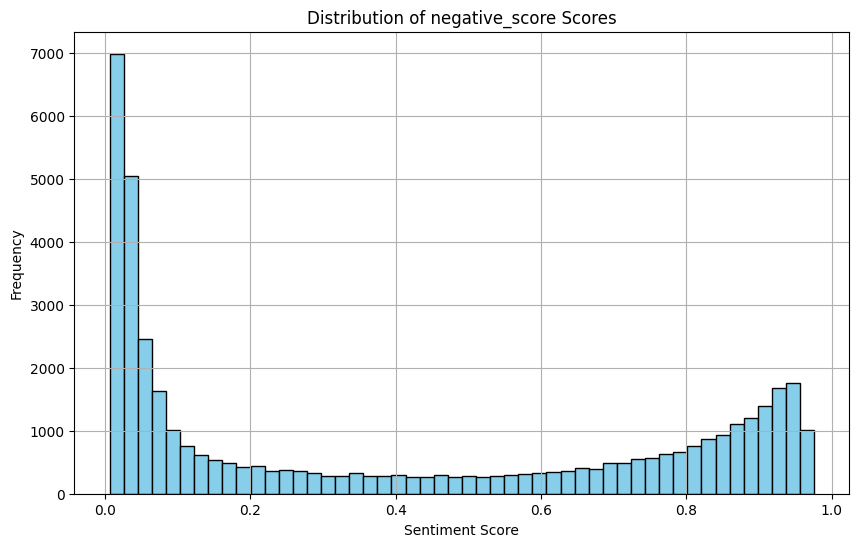

In [ ]:
from src.utils.plot_df import plot_sentiment_score_distribution

plot_sentiment_score_distribution(filtered_df, 'positive_score')
plot_sentiment_score_distribution(filtered_df, 'neutral_score')
plot_sentiment_score_distribution(filtered_df, 'negative_score')

# Classify the news into categories based on the description
| Category         | Example Input                             |
|------------------|------------------------------------------|
| Market-wide      | “Fed announces rate hike”                |
| Sector-specific  | “Semiconductor shortages worsen”         |
| Stock-specific   | “AAPL Q3 earnings beat expectations”     |
| Irrelevant       | “U.K. royal family attends charity gala” |